# Building cancer-detection system with RadIO

In [1]:
PATH_TO_FOLDER = '../../../pydata/' # your local path do downloaded folder
# PATH_TO_SAMPLE = '/home/aleQxander/Work/Temp/unrarred/needed/other/_demo_data/'

## 1. CT-scans and Lung-cancer

In [2]:
# some imports
import os

import numpy as np
from ipywidgets import interact
from utils import pil_plot_slices, load_example, show_slices, get_pixel_coords

import sys  # no need
sys.path.append('..') # no need

from radio.dataset import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB

* CT-scans are 3d-arrays of data. Cancer in lungs is represented in *pulmonary nodules*:

In [3]:
# plot a scan and a corresponding mask
PATH_TO_SAMPLE = os.path.join(PATH_TO_FOLDER, 'data/scans_sample/')

bch = load_example(PATH_TO_SAMPLE)
interact(lambda height: pil_plot_slices(height, bch.get(0, 'images'), bch.get(0, 'masks')),
         height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>

## 3. Building detection system-workflow

### `Dataset` and `Pipeline`

CT-scans are voluminous. It is not possible to store all scans from the dataset in memory at once. In order to work with the dataset of scans, we create `Dataset`: an *indexing strructure*:

In [4]:
luna_index = FilesIndex(path=os.path.join(PATH_TO_FOLDER, 'data/sample_raw/*.mhd'),
                        no_ext=True)                                    # preparing indexing structure
lunaset = Dataset(index=luna_index, batch_class=CTIMB)  # Dataset: logic + indexing structure

In [5]:
luna_index.indices[:3]

array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998'],
      dtype='<U100')

In [6]:
luna_index.get_fullpath(luna_index.indices[0])

'../../../pydata/data/sample_raw/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd'

Data-processing workflows are called `pipelines`, which represent sequences(plans) of actions on data

To perform some real computation we need to pass a batch through a `pipeline`:

### 3.1 Preprocessing

First things first: load the data. `RadIO` uses asychronous loading with `aiofiles`. Should be fast!

In [7]:
preprocessing = (Pipeline()
                 .load(fmt='raw', components=['images', 'spacing', 'origin']))

Luna-dataset provides cancer-annotations for targets:

In [8]:
ANNO_PATH = os.path.join(PATH_TO_FOLDER, 'data/annotations.csv')

In [9]:
import pandas as pd
nodules_df = pd.read_csv(ANNO_PATH)
nodules_df.head(2)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708


Make use of it!

In [10]:
preprocessing += (Pipeline()
                  .fetch_nodules_info(nodules_df)
                  .create_mask()
                  .normalize_hu())

Also we normalize data-range to [0, 255]

Perhaps you need to `dump` preprocessed scans and get back to them later?

In [11]:
dumping = (Pipeline()
           .dump(fmt='blosc', dst=os.path.join(PATH_TO_FOLDER, 'data/raw_blosc/'),
                 components=['images', 'masks', 'spacing', 'origin'], i8_encoding_mode='linear'))

In [16]:
# batch = (lunaset >> (preprocessing + dumping)).next_batch(1) # Do not run this cell if you have less than 8GB RAM

In [12]:
two_scans_dataset = Dataset(index=FilesIndex(path=os.path.join(PATH_TO_FOLDER, 'data/raw_blosc/*'),
                            dirs=True), batch_class=CTIMB)

preprocessing_raw = Pipeline().load(fmt='blosc', components=['images', 'spacing', 'origin'])
batch = (two_scans_dataset >> preprocessing_raw).next_batch(2, shuffle=False)

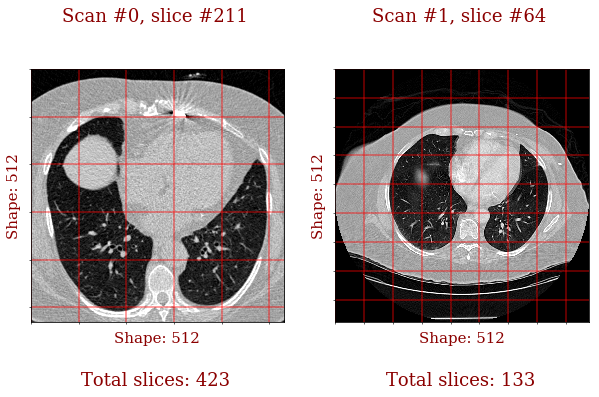

In [13]:
show_slices(batch, scan_indices=[0, 1], ns_slice=[211, 64], grid=True, clims=(0, 255))

One can see that the lungs are larger on the left scan. This can be explained by a big difference in scale (represented by a grid). This can be a source of uncontrollable variation in the training dataset. In order to make scans more isotropic, we add action `unify_spacing` to our preprocessing workflow.

In [14]:
SHAPE = (256, 256, 256)
SPACING = (1.7, 1., 1.)

In [15]:
preprocessing_raw += (Pipeline()
                      .unify_spacing(spacing=SPACING, shape=SHAPE, padding='constant'))

Now pass a batch through the workflow and see the difference:

In [16]:
batch = (two_scans_dataset >> preprocessing_raw).next_batch(2)

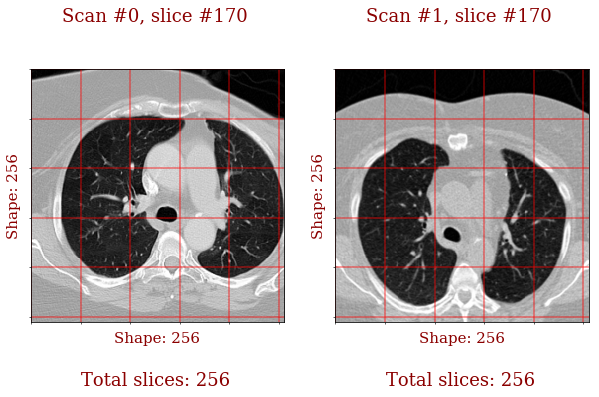

In [17]:
show_slices(batch, scan_indices=[0, 1], ns_slice=[170, 170], grid=True, clims=(0, 255))

### 3.2 Augmentation

In [41]:
LUNA_BLOSC = os.path.join(PATH_TO_FOLDER, 'data/scans_sample/*')
luna_blosc = Dataset(FilesIndex(path=LUNA_BLOSC, dirs=True), batch_class=CTIMB)

Let us add some augmentation actions to the workflow. To begin with, let's *controllably* introduce variation into the scale by randomly zooming in/zooming out on scans:

In [42]:
spacing_options = [(1.7, 0.8, 0.8), (1.7, 1.0, 1.0), (1.7, 1.2, 1.2), (1.7, 1.4, 1.4)]

here we define spacing randomizer, a function that randomly fetches spacing:

In [43]:
spacing_randomizer = lambda *args: spacing_options[np.random.choice(range(len(spacing_options)))]

In [51]:
preprocessing = (Pipeline()
                 .load(fmt='blosc', components=['images', 'spacing', 'origin', 'masks'])
                 .fetch_nodules_info(nodules_df)
                 .create_mask())

In [52]:
from radio.dataset import F
augmentation = (Pipeline()
                 .rotate(random=True, angle=10, components=['images', 'masks'])
                 .unify_spacing(spacing=F(spacing_randomizer), shape=(128, 256, 256), padding='constant'))

add some rotation:

In [53]:
batch = (luna_blosc >> (preprocessing + augmentation)).next_batch(1)

In [47]:
interact(lambda height: pil_plot_slices(height, batch.get(0, 'images'), batch.get(0, 'masks')),
         height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>

### MIPs: a way to reduce 3d-problem to a 2d-one

Approach of participants in `Kaggle-DsBowl` and `Luna-challenge`: train network on small crops as 1) modern **GPUs** are just not enough to store full scans and 2) it's a way of augmenting the dataset. This approach leads to inference that takes **a lot** of time. Our approach: add *Maximum Intensity Projection (MIP)* in preprocessing.

In [48]:
xips = batch.xip('images', mode='max', depth=7, stride=3)

In [49]:
lxip = int(len(xips) / len(batch))

In [50]:
interact(lambda height: pil_plot_slices(height, batch.get(0, 'images'), xips[0:lxip, :, :, 0],
                                        batch.get(0, 'masks')),
         height=(0, 0.99, 0.005))

interactive(children=(FloatSlider(value=0.495, description='height', max=0.99, step=0.005), Output()), _dom_cl…

<function __main__.<lambda>(height)>

### 3.3 Model training

Module `dataset` contains a zoo of neural network models written on `tensorflow` and (coming soon) `pytorch`. Firstly, choose a model from the zoo:

In [54]:
# more imports
import tensorflow as tf
from radio.dataset import B, V, F
from radio.dataset.models.tf import TFModel, UNet
from radio.dataset.models.tf.losses import dice

The next step is configuring a model:

In [55]:
model_config = dict(
    inputs=dict(
        images=dict(shape=(256, 256, 1)),
        masks=dict(shape=(256, 256, 1), name='targets')
    ),
    input_block=dict(inputs='images'),
    output=dict(ops='sigmoid'),
    loss=dice,
    optimizer='Adam')

In [61]:
# init model in pipeline, assemble training pipeline
XIP_PARAMS = dict(mode='max', depth=6, stride=2, channels=1)
model_training = (Pipeline()
                  .init_model('static', UNet, 'unet', model_config)
                  .train_model('unet', feed_dict=dict(images=F(CTIMB.xip,
                                                                 component='images', **XIP_PARAMS))))

combining all parts into one workflow

In [62]:
workflow = (preprocessing + augmentation + model_training) << luna_blosc

training cycle

In [ ]:
N_ITERS = 1
for i in range(N_ITERS):
    # workflow.next_batch(1)
    pass

### 3.4 Inference using pretrained model

In [5]:
import tensorflow as tf
from radio.dataset import B, V, F
from radio.dataset.models.tf import TFModel

model_path = os.path.join(PATH_TO_FOLDER, 'unet/e_6_3c_unet/models/logloss/')
config = dict(load=dict(path=model_path),
              session=dict(config=tf.ConfigProto(allow_soft_placement=True)))

XIP_PARAMS = dict(mode='max', depth=6, stride=2, channels=3)

ppl_predict_scan = (Pipeline()
                    .init_model('static', TFModel, 'xipnet', config)
                    .load(fmt='blosc', components=['images', 'spacing', 'origin', 'masks'])
                    .fetch_nodules_from_mask()
                    .init_variables(['predictions', 'nodules_true', 'nodules_predicted'])
                    .fetch_nodules_from_mask()
                    .update_variable('nodules_true', B('nodules'))
                    .predict_model('xipnet', save_to=V('predictions'),
                                   feed_dict=dict(images=F(CTIMB.xip, component='images', **XIP_PARAMS)))
                    .call(CTIMB.unxip, xip=V('predictions'), squeeze=True, **XIP_PARAMS,
                          component='predictions')
                    .fetch_nodules_from_mask()
                    .update_variable('nodules_predicted', B('nodules')) << luna_blosc)

INFO:tensorflow:Restoring parameters from ../../../pydata/unet/e_6_3c_unet/models/logloss/model-230000


In [6]:
btch = ppl_predict_scan.next_batch(1)

In [7]:
interact(lambda height: pil_plot_slices(height, btch.get(0, 'images'), btch.masks, 
                                        btch.predictions), height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>